###  Created by Luis A. Sanchez-Perez (alejand@umich.edu).
<p><span style="color:green"><b>Copyright &#169;</b> Do not distribute or use without authorization from author.</span></p>

Training logistic regression models with regularization using python optimization [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) function to solve unconstrained optimization problems on a simulated dataset. Uses polynomial expansion to fit non-linear boundaries. Also computes training metrics.

In [1]:
import scipy.io as sio
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

In [2]:
# Functions
def sigmoid(x):
    return 1. / (1. + np.exp(-x))
    
# Functions
def cost(w,X,y,reg):
    h = sigmoid(X.dot(w))
    loglikelihood = sum([np.log(prob) if label else np.log(1-prob) for prob,label in zip(h,y)]) 
    loglikelihood -= reg*(w[1:]**2).sum()
    return -loglikelihood

def cost_grad(w,X,y,reg):
    h = sigmoid(X.dot(w))
    grad = (X.T).dot(h - y) + np.concatenate(([0],reg * w[1:]))
    return grad

def plot_boundary(w,X_train,y_train,X_test,y_test,mesh,threshold):
    # training set
    plt.scatter(X_train[:,1],X_train[:,2], c=y_train, s=40, cmap='viridis', edgecolor='k')
    # boundary
    pts = int(np.sqrt(mesh.shape[0]))
    x1 = mesh[:,1].reshape((pts,pts))
    x2 = mesh[:,2].reshape((pts,pts))
    h = sigmoid(mesh.dot(w))
    y_pred = h.reshape((pts,pts))
    plt.contour(x1, x2, y_pred, levels = [threshold], colors='black')
    plt.contourf(x1, x2, y_pred >= threshold, alpha = 0.10, cmap='viridis')
    # test set
    h = sigmoid(X_test.dot(w))
    y_pred = (h >= threshold)
    correct = (y_pred == y_test)
    positive = (y_pred == 1)
    tp = correct & positive
    tn = correct & ~positive
    fp = ~correct & positive
    fn = ~correct & ~positive
    plt.scatter(X_test[tp,1],X_test[tp,2], marker='.', c='black', s=60)
    plt.scatter(X_test[tn,1],X_test[tn,2], marker='.', c='black', s=60)
    plt.scatter(X_test[fp,1],X_test[fp,2], marker='x', c='black', s=60)
    plt.scatter(X_test[fn,1],X_test[fn,2], marker='x', c='black', s=60)
    
def compute_metrics(w,X_train,y_train,X_test,y_test):
    # trainig metrics
    h = sigmoid(X_train.dot(w))
    y_pred = (h >= threshold)
    print('Training Metrics:')
    print('Accuracy: ', '%.2f'  % accuracy_score(y_train, y_pred))
    print('F1 Score: ', '%.2f'  % f1_score(y_train, y_pred))
    print('Recall: ', '%.2f'  % recall_score(y_train, y_pred))
    print('Precision: ', '%.2f'  % precision_score(y_train, y_pred))
    h = sigmoid(X_test.dot(w))
    y_pred = (h >= threshold)
    print('\nTest Metrics:')
    print('Accuracy: ', '%.2f'  % accuracy_score(y_test, y_pred))
    print('F1 Score: ', '%.2f'  % f1_score(y_test, y_pred))
    print('Recall: ', '%.2f'  % recall_score(y_test, y_pred))
    print('Precision: ', '%.2f'  % precision_score(y_test, y_pred))

In [3]:
# Read data and build 2D mesh
dataset = sio.loadmat('../../datasets/classification/demolog1.mat')
X = dataset['X']
y = dataset['y'].flatten()
bottom = np.min(X,0)
top = np.max(X,0)
pts = 500
mx = np.linspace(bottom[0], top[0], pts)  # x1
my = np.linspace(bottom[1], top[1], pts)  # x2
mx, my = np.meshgrid(mx, my)
mesh = np.vstack((mx.flatten(), my.flatten())).T
d = 10
ps = PolynomialFeatures(degree=d)
ps.fit(X)
X = ps.transform(X)
mesh = ps.transform(mesh)
sc = StandardScaler()
sc.fit(X[:,1:])
X[:,1:] = sc.transform(X[:,1:])
mesh[:,1:] = sc.transform(mesh[:,1:])

In [4]:
# Params
reg = 0.1
threshold = 0.5
#rnd.seed(10)
w0 = 1e-4 * rnd.rand(X.shape[1])

In [5]:
# Splits into training/test set
pct = 0.7
m = y.shape[0]
i = np.random.permutation(m)
X = X[i,:];
y = y[i]
m = round(pct*m)
X_train = X[:m,:]
X_test = X[m:,:]
y_train = y[:m].ravel()
y_test = y[m:].ravel()

Training Metrics:
Accuracy:  0.72
F1 Score:  0.77
Recall:  0.88
Precision:  0.68

Test Metrics:
Accuracy:  0.69
F1 Score:  0.69
Recall:  0.80
Precision:  0.60


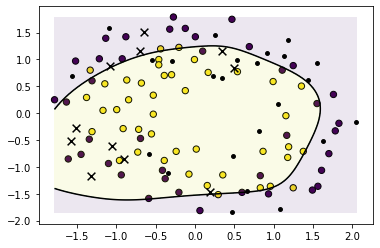

In [6]:
# Solves for w using Nelder-Mead method (derivative-free method)
op = {'fatol': 1e-8}
result = opt.minimize(cost, w0, method = 'Nelder-Mead', 
                      args = (X_train,y_train,reg),
                      options = op)
w = result.x
# Plots resulting model
plot_boundary(w,X_train,y_train,X_test,y_test,mesh,threshold)
compute_metrics(w,X_train,y_train,X_test,y_test)

Training Metrics:
Accuracy:  0.89
F1 Score:  0.90
Recall:  0.93
Precision:  0.87

Test Metrics:
Accuracy:  0.80
F1 Score:  0.76
Recall:  0.73
Precision:  0.79


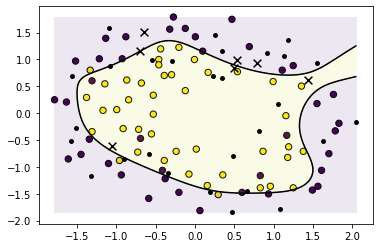

In [7]:
# Solves for w using L-BFGS-B (quasi newtown's method)
op = {'gtol': 1e-8}
result = opt.minimize(cost, w0, method = 'L-BFGS-B',
                      jac = cost_grad,
                      args = (X_train,y_train,reg), options = op)
w = result.x
# Plots resulting model
plot_boundary(w,X_train,y_train,X_test,y_test,mesh,threshold)
compute_metrics(w,X_train,y_train,X_test,y_test)

Training Metrics:
Accuracy:  0.87
F1 Score:  0.88
Recall:  0.93
Precision:  0.83

Test Metrics:
Accuracy:  0.83
F1 Score:  0.80
Recall:  0.80
Precision:  0.80


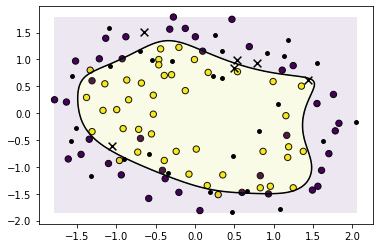

In [8]:
# Solves for w using BFGS (quasi newtown's method)
op = {'xtol': 1e-8}
result = opt.minimize(cost, w0, method = 'Newton-CG',
                      jac = cost_grad, 
                      args = (X_train,y_train,reg), options = op)
w = result.x
# Plots resulting model
plot_boundary(w,X_train,y_train,X_test,y_test,mesh,threshold)
compute_metrics(w,X_train,y_train,X_test,y_test)

Training Metrics:
Accuracy:  0.88
F1 Score:  0.89
Recall:  0.93
Precision:  0.85

Test Metrics:
Accuracy:  0.86
F1 Score:  0.83
Recall:  0.80
Precision:  0.86


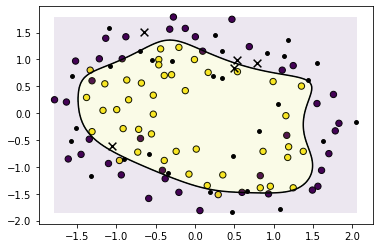

In [9]:
# Solves for w using BFGS (quasi newtown's method)
op = {'gtol': 1e-8}
result = opt.minimize(cost, w0, method = 'BFGS',
                      jac = cost_grad,
                      args = (X_train,y_train,reg), options = op)
w = result.x
# Plots resulting model
plot_boundary(w,X_train,y_train,X_test,y_test,mesh,threshold)
compute_metrics(w,X_train,y_train,X_test,y_test)